Using cache found in C:\Users\ayham/.cache\torch\hub\snakers4_silero-models_master



Processing sentence 1

Reference text: The mute muffled the high tones of the horn.
Recognized text: the mute muffled the high tones of the horn
WER: 20.00%, WCR: 80.00%, Audio dur: 3.50s, Processing: 0.49s, RTF: 0.141

Processing sentence 2

Reference text: The dark pot hung in the front closet.
Recognized text: the dark pot hung in the front closet
WER: 22.22%, WCR: 77.78%, Audio dur: 3.14s, Processing: 0.57s, RTF: 0.182

Processing sentence 3

Reference text: Take the beer out of the fridge.
Recognized text: take the beer out of the open fridge
WER: 37.50%, WCR: 62.50%, Audio dur: 3.15s, Processing: 0.05s, RTF: 0.015

Processing sentence 4

Reference text: Sickness kept him home for three weeks.
Recognized text: sickness kept him home for three weeks
WER: 25.00%, WCR: 75.00%, Audio dur: 3.26s, Processing: 0.06s, RTF: 0.017

Processing sentence 5

Reference text: The loss of the cruiser was a blow to the fleet.
Recognized text: the loss of the cruiser was a blow to the fleet
WER: 16

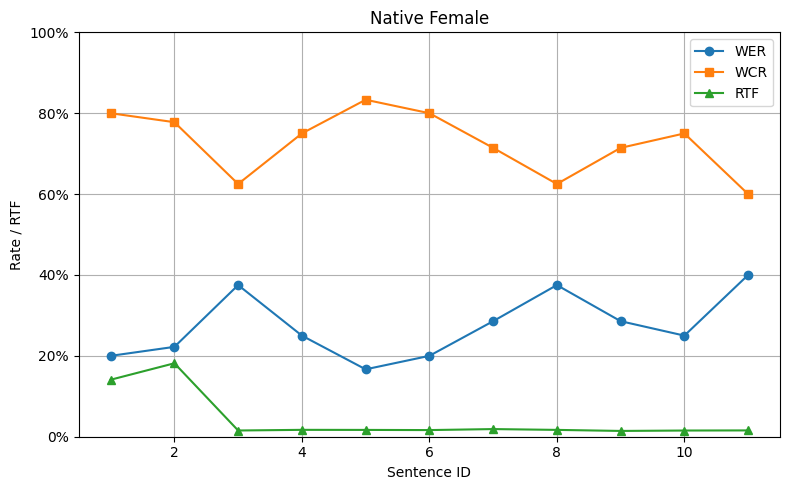

In [3]:
import os
import time
import re
import torch
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.signal import resample_poly
from collections import defaultdict

# =========================================================
# CONFIG
# =========================================================
TARGET_WORD = "mute"   # word of interest (case-sensitive)
audio_dir = r"C:\Users\ayham\Desktop\Downloads\HMI SpeechRecognition Dataset\Audio Files HMI\Native Female\wav"
transcript_path = r"C:\Users\ayham\Desktop\Downloads\HMI SpeechRecognition Dataset\Audio Files HMI\transcript.txt"
num_sentences = 11

# =========================================================
# Load reference sentence by ID
# =========================================================
def load_reference_by_id(path: str, sentence_id: int) -> str:
    prefix = f"{sentence_id}:"
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line.startswith(prefix):
                text = line[len(prefix):].strip()
                text = re.sub(r"\(.*?\)", "", text).strip()
                return text
    raise ValueError(f"Sentence ID {sentence_id} not found in transcript file")

# =========================================================
# Punctuation-aware tokenizer
# =========================================================
def tokenize_with_punctuation(text: str) -> list[str]:
    return re.findall(r"\w+|[^\w\s]", text)

# =========================================================
# Word-level alignment (Levenshtein)
# =========================================================
def align_words(ref_tokens, hyp_tokens):
    n, m = len(ref_tokens), len(hyp_tokens)
    dp = [[0] * (m + 1) for _ in range(n + 1)]

    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if ref_tokens[i - 1] == hyp_tokens[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(
                    dp[i - 1][j],
                    dp[i][j - 1],
                    dp[i - 1][j - 1]
                )

    i, j = n, m
    ops = []
    while i > 0 or j > 0:
        if i > 0 and j > 0 and ref_tokens[i - 1] == hyp_tokens[j - 1]:
            ops.append(("CORRECT", ref_tokens[i - 1]))
            i -= 1
            j -= 1
        elif i > 0 and j > 0 and dp[i][j] == dp[i - 1][j - 1] + 1:
            ops.append(("SUB", ref_tokens[i - 1], hyp_tokens[j - 1]))
            i -= 1
            j -= 1
        elif i > 0 and dp[i][j] == dp[i - 1][j] + 1:
            ops.append(("DEL", ref_tokens[i - 1]))
            i -= 1
        else:
            ops.append(("INS", hyp_tokens[j - 1]))
            j -= 1

    return reversed(ops)

# =========================================================
# Silero STT transcription
# =========================================================
def transcribe_audio(model, decoder, prepare_model_input, path: str):
    start_time = time.time()
    audio, sr = sf.read(path)
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)
    if sr != 16000:
        audio = resample_poly(audio, 16000, sr)
        sr = 16000

    audio_tensor = torch.from_numpy(audio).float().unsqueeze(0)
    input_tensor = prepare_model_input(audio_tensor, device="cpu")

    with torch.no_grad():
        output = model(input_tensor)

    recognized_text = decoder(output[0].cpu())
    processing_time = time.time() - start_time
    return recognized_text, processing_time, len(audio)/sr

# =========================================================
# MAIN
# =========================================================
if __name__ == "__main__":

    wer_list, wcr_list, rtf_list = [], [], []
    total_wer, total_wcr, total_rtf = 0.0, 0.0, 0.0

    # Word-level counts for all words
    word_counts = defaultdict(lambda: {"TP":0, "FP":0, "FN":0})

    # =============================
    # Load Silero model ONCE
    # =============================
    device = torch.device("cpu")
    model, decoder, utils = torch.hub.load(
        repo_or_dir="snakers4/silero-models",
        model="silero_stt",
        language="en",
        device=device
    )
    (_, _, _, prepare_model_input) = utils

    # =============================
    # Process each sentence
    # =============================
    for sentence_id in range(1, num_sentences+1):

        print("\n" + "="*60)
        print(f"Processing sentence {sentence_id}")
        print("="*60)

        audio_path = os.path.join(audio_dir, f"{sentence_id}.wav")
        reference_text = load_reference_by_id(transcript_path, sentence_id)
        print("\nReference text:", reference_text)

        recognized_text, processing_time, audio_duration = transcribe_audio(model, decoder, prepare_model_input, audio_path)
        print("Recognized text:", recognized_text)

        ref_tokens = tokenize_with_punctuation(reference_text)
        rec_tokens = tokenize_with_punctuation(recognized_text)

        ops = list(align_words(ref_tokens, rec_tokens))

        # Update word-level counts
        for op in ops:
            if op[0] == "CORRECT":
                word_counts[op[1]]["TP"] += 1
            elif op[0] == "SUB":
                ref_w, hyp_w = op[1], op[2]
                word_counts[ref_w]["FN"] += 1
                word_counts[hyp_w]["FP"] += 1
            elif op[0] == "DEL":
                word_counts[op[1]]["FN"] += 1
            elif op[0] == "INS":
                word_counts[op[1]]["FP"] += 1

        # WER/WCR
        subs = sum(1 for o in ops if o[0]=="SUB")
        dels = sum(1 for o in ops if o[0]=="DEL")
        ins = sum(1 for o in ops if o[0]=="INS")
        wer = (subs + dels + ins)/len(ref_tokens)
        wcr = (len(ref_tokens) - subs - dels)/len(ref_tokens)

        wer_list.append(wer)
        wcr_list.append(wcr)
        total_wer += wer
        total_wcr += wcr
        rtf = processing_time / audio_duration
        rtf_list.append(rtf)
        total_rtf += rtf

        print(f"WER: {wer:.2%}, WCR: {wcr:.2%}, Audio dur: {audio_duration:.2f}s, Processing: {processing_time:.2f}s, RTF: {rtf:.3f}")

    # =========================================================
    # Per-word metrics for TARGET_WORD
    # =========================================================
    TP = word_counts[TARGET_WORD]["TP"]
    FP = word_counts[TARGET_WORD]["FP"]
    FN = word_counts[TARGET_WORD]["FN"]
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = (2*precision*recall/(precision+recall)) if (precision+recall) > 0 else 0.0

    print("\n" + "="*60)
    print(f"Metrics for word '{TARGET_WORD}': Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

    # =========================================================
    # Macro / Micro averages over vocabulary
    # =========================================================
    macro_prec = 0.0
    macro_rec = 0.0
    for w, counts in word_counts.items():
        TP_w, FP_w, FN_w = counts["TP"], counts["FP"], counts["FN"]
        macro_prec += TP_w / (TP_w + FP_w) if (TP_w + FP_w) > 0 else 0
        macro_rec += TP_w / (TP_w + FN_w) if (TP_w + FN_w) > 0 else 0
    macro_prec /= len(word_counts)
    macro_rec /= len(word_counts)

    total_TP = sum(c["TP"] for c in word_counts.values())
    total_FP = sum(c["FP"] for c in word_counts.values())
    total_FN = sum(c["FN"] for c in word_counts.values())
    micro_prec = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
    micro_rec = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0

    print("\nMacro-averaged: Precision={:.3f}, Recall={:.3f}".format(macro_prec, macro_rec))
    print("Micro-averaged: Precision={:.3f}, Recall={:.3f}".format(micro_prec, micro_rec))

    # =========================================================
    # Average WER/WCR/RTF
    # =========================================================
    print("\n" + "="*60)
    print(f"AVERAGE WER: {total_wer/num_sentences:.2%}")
    print(f"AVERAGE WCR: {total_wcr/num_sentences:.2%}")
    print(f"AVERAGE RTF: {total_rtf/num_sentences:.3f}")

    # =========================================================
    # Plot WER/WCR/RTF
    # =========================================================
    sentence_ids = list(range(1, num_sentences+1))
    plt.figure(figsize=(8,5))
    plt.plot(sentence_ids, wer_list, marker='o', label="WER")
    plt.plot(sentence_ids, wcr_list, marker='s', label="WCR")
    plt.plot(sentence_ids, rtf_list, marker='^', label="RTF")
    plt.title("Native Female")
    plt.xlabel("Sentence ID")
    plt.ylabel("Rate / RTF")
    plt.ylim(0,1)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Using cache found in C:\Users\ayham/.cache\torch\hub\snakers4_silero-models_master



Processing sentence 1

Reference text: The mute muffled the high tones of the horn.
Recognized text: the mute muffled the hightones of the horn
WER: 40.00%, WCR: 60.00%, Audio dur: 3.71s, Processing: 0.52s, RTF: 0.140

Processing sentence 2

Reference text: The dark pot hung in the front closet.
Recognized text: the dark pt hung in the front closet
WER: 33.33%, WCR: 66.67%, Audio dur: 3.62s, Processing: 0.46s, RTF: 0.128

Processing sentence 3

Reference text: Take the beer out of the fridge.
Recognized text: take the beer out of the fridge
WER: 25.00%, WCR: 75.00%, Audio dur: 3.36s, Processing: 0.06s, RTF: 0.018

Processing sentence 4

Reference text: Sickness kept him home for three weeks.
Recognized text: sickness kept him home for three weeks
WER: 25.00%, WCR: 75.00%, Audio dur: 3.88s, Processing: 0.07s, RTF: 0.018

Processing sentence 5

Reference text: The loss of the cruiser was a blow to the fleet.
Recognized text: the loss of the cruiser was a blow for the fleet
WER: 25.00%, 

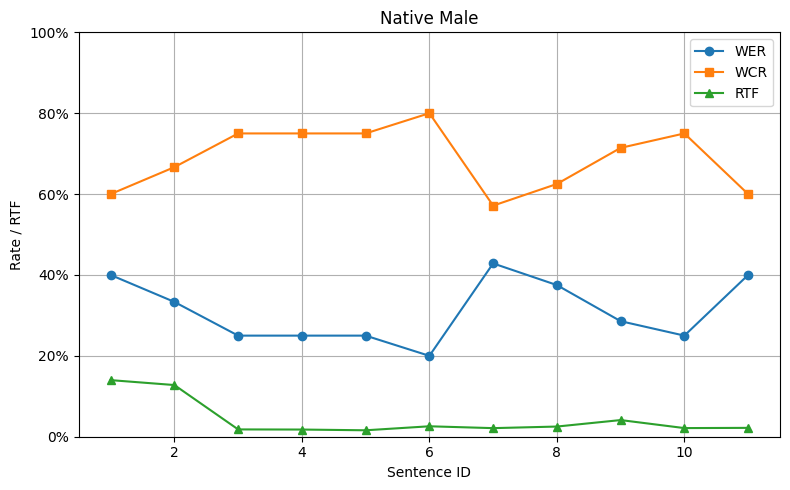

In [7]:
import os
import time
import re
import torch
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.signal import resample_poly
from collections import defaultdict

# =========================================================
# CONFIG
# =========================================================
TARGET_WORD = "mute"   # word of interest (case-sensitive)
audio_dir = r"C:\Users\ayham\Desktop\Downloads\HMI SpeechRecognition Dataset\Audio Files HMI\Native Male\wav"
transcript_path = r"C:\Users\ayham\Desktop\Downloads\HMI SpeechRecognition Dataset\Audio Files HMI\transcript.txt"
num_sentences = 11

# =========================================================
# Load reference sentence by ID
# =========================================================
def load_reference_by_id(path: str, sentence_id: int) -> str:
    prefix = f"{sentence_id}:"
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line.startswith(prefix):
                text = line[len(prefix):].strip()
                text = re.sub(r"\(.*?\)", "", text).strip()
                return text
    raise ValueError(f"Sentence ID {sentence_id} not found in transcript file")

# =========================================================
# Punctuation-aware tokenizer
# =========================================================
def tokenize_with_punctuation(text: str) -> list[str]:
    return re.findall(r"\w+|[^\w\s]", text)

# =========================================================
# Word-level alignment (Levenshtein)
# =========================================================
def align_words(ref_tokens, hyp_tokens):
    n, m = len(ref_tokens), len(hyp_tokens)
    dp = [[0] * (m + 1) for _ in range(n + 1)]

    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if ref_tokens[i - 1] == hyp_tokens[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(
                    dp[i - 1][j],
                    dp[i][j - 1],
                    dp[i - 1][j - 1]
                )

    i, j = n, m
    ops = []
    while i > 0 or j > 0:
        if i > 0 and j > 0 and ref_tokens[i - 1] == hyp_tokens[j - 1]:
            ops.append(("CORRECT", ref_tokens[i - 1]))
            i -= 1
            j -= 1
        elif i > 0 and j > 0 and dp[i][j] == dp[i - 1][j - 1] + 1:
            ops.append(("SUB", ref_tokens[i - 1], hyp_tokens[j - 1]))
            i -= 1
            j -= 1
        elif i > 0 and dp[i][j] == dp[i - 1][j] + 1:
            ops.append(("DEL", ref_tokens[i - 1]))
            i -= 1
        else:
            ops.append(("INS", hyp_tokens[j - 1]))
            j -= 1

    return reversed(ops)

# =========================================================
# Silero STT transcription
# =========================================================
def transcribe_audio(model, decoder, prepare_model_input, path: str):
    start_time = time.time()
    audio, sr = sf.read(path)
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)
    if sr != 16000:
        audio = resample_poly(audio, 16000, sr)
        sr = 16000

    audio_tensor = torch.from_numpy(audio).float().unsqueeze(0)
    input_tensor = prepare_model_input(audio_tensor, device="cpu")

    with torch.no_grad():
        output = model(input_tensor)

    recognized_text = decoder(output[0].cpu())
    processing_time = time.time() - start_time
    return recognized_text, processing_time, len(audio)/sr

# =========================================================
# MAIN
# =========================================================
if __name__ == "__main__":

    wer_list, wcr_list, rtf_list = [], [], []
    total_wer, total_wcr, total_rtf = 0.0, 0.0, 0.0

    # Word-level counts for all words
    word_counts = defaultdict(lambda: {"TP":0, "FP":0, "FN":0})

    # =============================
    # Load Silero model ONCE
    # =============================
    device = torch.device("cpu")
    model, decoder, utils = torch.hub.load(
        repo_or_dir="snakers4/silero-models",
        model="silero_stt",
        language="en",
        device=device
    )
    (_, _, _, prepare_model_input) = utils

    # =============================
    # Process each sentence
    # =============================
    for sentence_id in range(1, num_sentences+1):

        print("\n" + "="*60)
        print(f"Processing sentence {sentence_id}")
        print("="*60)

        audio_path = os.path.join(audio_dir, f"{sentence_id}.wav")
        reference_text = load_reference_by_id(transcript_path, sentence_id)
        print("\nReference text:", reference_text)

        recognized_text, processing_time, audio_duration = transcribe_audio(model, decoder, prepare_model_input, audio_path)
        print("Recognized text:", recognized_text)

        ref_tokens = tokenize_with_punctuation(reference_text)
        rec_tokens = tokenize_with_punctuation(recognized_text)

        ops = list(align_words(ref_tokens, rec_tokens))

        # Update word-level counts
        for op in ops:
            if op[0] == "CORRECT":
                word_counts[op[1]]["TP"] += 1
            elif op[0] == "SUB":
                ref_w, hyp_w = op[1], op[2]
                word_counts[ref_w]["FN"] += 1
                word_counts[hyp_w]["FP"] += 1
            elif op[0] == "DEL":
                word_counts[op[1]]["FN"] += 1
            elif op[0] == "INS":
                word_counts[op[1]]["FP"] += 1

        # WER/WCR
        subs = sum(1 for o in ops if o[0]=="SUB")
        dels = sum(1 for o in ops if o[0]=="DEL")
        ins = sum(1 for o in ops if o[0]=="INS")
        wer = (subs + dels + ins)/len(ref_tokens)
        wcr = (len(ref_tokens) - subs - dels)/len(ref_tokens)

        wer_list.append(wer)
        wcr_list.append(wcr)
        total_wer += wer
        total_wcr += wcr
        rtf = processing_time / audio_duration
        rtf_list.append(rtf)
        total_rtf += rtf

        print(f"WER: {wer:.2%}, WCR: {wcr:.2%}, Audio dur: {audio_duration:.2f}s, Processing: {processing_time:.2f}s, RTF: {rtf:.3f}")

    # =========================================================
    # Per-word metrics for TARGET_WORD
    # =========================================================
    TP = word_counts[TARGET_WORD]["TP"]
    FP = word_counts[TARGET_WORD]["FP"]
    FN = word_counts[TARGET_WORD]["FN"]
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = (2*precision*recall/(precision+recall)) if (precision+recall) > 0 else 0.0

    print("\n" + "="*60)
    print(f"Metrics for word '{TARGET_WORD}': Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

    # =========================================================
    # Macro / Micro averages over vocabulary
    # =========================================================
    macro_prec = 0.0
    macro_rec = 0.0
    for w, counts in word_counts.items():
        TP_w, FP_w, FN_w = counts["TP"], counts["FP"], counts["FN"]
        macro_prec += TP_w / (TP_w + FP_w) if (TP_w + FP_w) > 0 else 0
        macro_rec += TP_w / (TP_w + FN_w) if (TP_w + FN_w) > 0 else 0
    macro_prec /= len(word_counts)
    macro_rec /= len(word_counts)

    total_TP = sum(c["TP"] for c in word_counts.values())
    total_FP = sum(c["FP"] for c in word_counts.values())
    total_FN = sum(c["FN"] for c in word_counts.values())
    micro_prec = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
    micro_rec = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0

    print("\nMacro-averaged: Precision={:.3f}, Recall={:.3f}".format(macro_prec, macro_rec))
    print("Micro-averaged: Precision={:.3f}, Recall={:.3f}".format(micro_prec, micro_rec))

    # =========================================================
    # Average WER/WCR/RTF
    # =========================================================
    print("\n" + "="*60)
    print(f"AVERAGE WER: {total_wer/num_sentences:.2%}")
    print(f"AVERAGE WCR: {total_wcr/num_sentences:.2%}")
    print(f"AVERAGE RTF: {total_rtf/num_sentences:.3f}")
    print("FP=", FP)

    # =========================================================
    # Plot WER/WCR/RTF
    # =========================================================
    sentence_ids = list(range(1, num_sentences+1))
    plt.figure(figsize=(8,5))
    plt.plot(sentence_ids, wer_list, marker='o', label="WER")
    plt.plot(sentence_ids, wcr_list, marker='s', label="WCR")
    plt.plot(sentence_ids, rtf_list, marker='^', label="RTF")
    plt.title("Native Male")
    plt.xlabel("Sentence ID")
    plt.ylabel("Rate / RTF")
    plt.ylim(0,1)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Using cache found in C:\Users\ayham/.cache\torch\hub\snakers4_silero-models_master



Processing sentence 1

Reference text: The mute muffled the high tones of the horn.
Recognized text: the mute muffled the he tons of the worn
WER: 50.00%, WCR: 50.00%, Audio dur: 4.84s, Processing: 0.63s, RTF: 0.130

Processing sentence 2

Reference text: The dark pot hung in the front closet.
Recognized text: the dark pa hung in the front closet
WER: 33.33%, WCR: 66.67%, Audio dur: 5.13s, Processing: 0.47s, RTF: 0.092

Processing sentence 3

Reference text: Take the beer out of the fridge.
Recognized text: take the bearout of the open fridge
WER: 62.50%, WCR: 37.50%, Audio dur: 4.21s, Processing: 0.15s, RTF: 0.037

Processing sentence 4

Reference text: Sickness kept him home for three weeks.
Recognized text: sickness kept him home for three weeks
WER: 25.00%, WCR: 75.00%, Audio dur: 5.29s, Processing: 0.21s, RTF: 0.039

Processing sentence 5

Reference text: The loss of the cruiser was a blow to the fleet.
Recognized text: the loss of the crucial was a blow to the flleet
WER: 33.33%

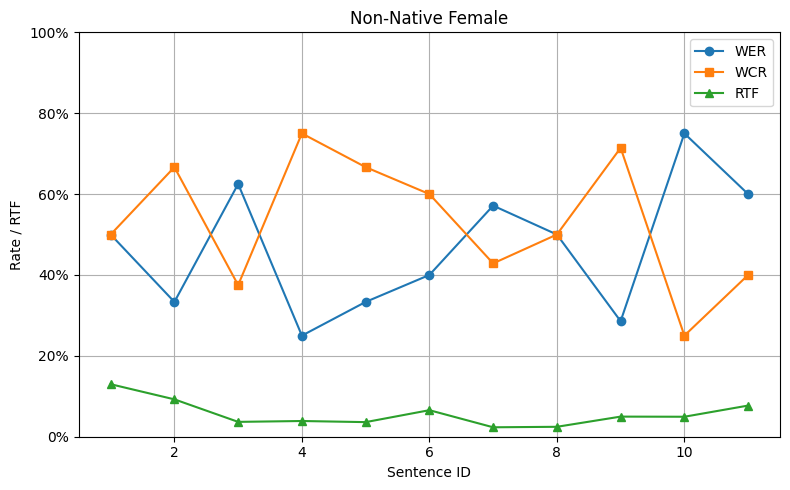

In [8]:
import os
import time
import re
import torch
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.signal import resample_poly
from collections import defaultdict

# =========================================================
# CONFIG
# =========================================================
TARGET_WORD = "mute"   # word of interest (case-sensitive)
audio_dir = r"C:\Users\ayham\Desktop\Downloads\HMI SpeechRecognition Dataset\Audio Files HMI\Non-Native Female\wav"
transcript_path = r"C:\Users\ayham\Desktop\Downloads\HMI SpeechRecognition Dataset\Audio Files HMI\transcript.txt"
num_sentences = 11

# =========================================================
# Load reference sentence by ID
# =========================================================
def load_reference_by_id(path: str, sentence_id: int) -> str:
    prefix = f"{sentence_id}:"
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line.startswith(prefix):
                text = line[len(prefix):].strip()
                text = re.sub(r"\(.*?\)", "", text).strip()
                return text
    raise ValueError(f"Sentence ID {sentence_id} not found in transcript file")

# =========================================================
# Punctuation-aware tokenizer
# =========================================================
def tokenize_with_punctuation(text: str) -> list[str]:
    return re.findall(r"\w+|[^\w\s]", text)

# =========================================================
# Word-level alignment (Levenshtein)
# =========================================================
def align_words(ref_tokens, hyp_tokens):
    n, m = len(ref_tokens), len(hyp_tokens)
    dp = [[0] * (m + 1) for _ in range(n + 1)]

    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if ref_tokens[i - 1] == hyp_tokens[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(
                    dp[i - 1][j],
                    dp[i][j - 1],
                    dp[i - 1][j - 1]
                )

    i, j = n, m
    ops = []
    while i > 0 or j > 0:
        if i > 0 and j > 0 and ref_tokens[i - 1] == hyp_tokens[j - 1]:
            ops.append(("CORRECT", ref_tokens[i - 1]))
            i -= 1
            j -= 1
        elif i > 0 and j > 0 and dp[i][j] == dp[i - 1][j - 1] + 1:
            ops.append(("SUB", ref_tokens[i - 1], hyp_tokens[j - 1]))
            i -= 1
            j -= 1
        elif i > 0 and dp[i][j] == dp[i - 1][j] + 1:
            ops.append(("DEL", ref_tokens[i - 1]))
            i -= 1
        else:
            ops.append(("INS", hyp_tokens[j - 1]))
            j -= 1

    return reversed(ops)

# =========================================================
# Silero STT transcription
# =========================================================
def transcribe_audio(model, decoder, prepare_model_input, path: str):
    start_time = time.time()
    audio, sr = sf.read(path)
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)
    if sr != 16000:
        audio = resample_poly(audio, 16000, sr)
        sr = 16000

    audio_tensor = torch.from_numpy(audio).float().unsqueeze(0)
    input_tensor = prepare_model_input(audio_tensor, device="cpu")

    with torch.no_grad():
        output = model(input_tensor)

    recognized_text = decoder(output[0].cpu())
    processing_time = time.time() - start_time
    return recognized_text, processing_time, len(audio)/sr

# =========================================================
# MAIN
# =========================================================
if __name__ == "__main__":

    wer_list, wcr_list, rtf_list = [], [], []
    total_wer, total_wcr, total_rtf = 0.0, 0.0, 0.0

    # Word-level counts for all words
    word_counts = defaultdict(lambda: {"TP":0, "FP":0, "FN":0})

    # =============================
    # Load Silero model ONCE
    # =============================
    device = torch.device("cpu")
    model, decoder, utils = torch.hub.load(
        repo_or_dir="snakers4/silero-models",
        model="silero_stt",
        language="en",
        device=device
    )
    (_, _, _, prepare_model_input) = utils

    # =============================
    # Process each sentence
    # =============================
    for sentence_id in range(1, num_sentences+1):

        print("\n" + "="*60)
        print(f"Processing sentence {sentence_id}")
        print("="*60)

        audio_path = os.path.join(audio_dir, f"{sentence_id}.wav")
        reference_text = load_reference_by_id(transcript_path, sentence_id)
        print("\nReference text:", reference_text)

        recognized_text, processing_time, audio_duration = transcribe_audio(model, decoder, prepare_model_input, audio_path)
        print("Recognized text:", recognized_text)

        ref_tokens = tokenize_with_punctuation(reference_text)
        rec_tokens = tokenize_with_punctuation(recognized_text)

        ops = list(align_words(ref_tokens, rec_tokens))

        # Update word-level counts
        for op in ops:
            if op[0] == "CORRECT":
                word_counts[op[1]]["TP"] += 1
            elif op[0] == "SUB":
                ref_w, hyp_w = op[1], op[2]
                word_counts[ref_w]["FN"] += 1
                word_counts[hyp_w]["FP"] += 1
            elif op[0] == "DEL":
                word_counts[op[1]]["FN"] += 1
            elif op[0] == "INS":
                word_counts[op[1]]["FP"] += 1

        # WER/WCR
        subs = sum(1 for o in ops if o[0]=="SUB")
        dels = sum(1 for o in ops if o[0]=="DEL")
        ins = sum(1 for o in ops if o[0]=="INS")
        wer = (subs + dels + ins)/len(ref_tokens)
        wcr = (len(ref_tokens) - subs - dels)/len(ref_tokens)

        wer_list.append(wer)
        wcr_list.append(wcr)
        total_wer += wer
        total_wcr += wcr
        rtf = processing_time / audio_duration
        rtf_list.append(rtf)
        total_rtf += rtf

        print(f"WER: {wer:.2%}, WCR: {wcr:.2%}, Audio dur: {audio_duration:.2f}s, Processing: {processing_time:.2f}s, RTF: {rtf:.3f}")

    # =========================================================
    # Per-word metrics for TARGET_WORD
    # =========================================================
    TP = word_counts[TARGET_WORD]["TP"]
    FP = word_counts[TARGET_WORD]["FP"]
    FN = word_counts[TARGET_WORD]["FN"]
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = (2*precision*recall/(precision+recall)) if (precision+recall) > 0 else 0.0

    print("\n" + "="*60)
    print(f"Metrics for word '{TARGET_WORD}': Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

    # =========================================================
    # Macro / Micro averages over vocabulary
    # =========================================================
    macro_prec = 0.0
    macro_rec = 0.0
    for w, counts in word_counts.items():
        TP_w, FP_w, FN_w = counts["TP"], counts["FP"], counts["FN"]
        macro_prec += TP_w / (TP_w + FP_w) if (TP_w + FP_w) > 0 else 0
        macro_rec += TP_w / (TP_w + FN_w) if (TP_w + FN_w) > 0 else 0
    macro_prec /= len(word_counts)
    macro_rec /= len(word_counts)

    total_TP = sum(c["TP"] for c in word_counts.values())
    total_FP = sum(c["FP"] for c in word_counts.values())
    total_FN = sum(c["FN"] for c in word_counts.values())
    micro_prec = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
    micro_rec = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0

    print("\nMacro-averaged: Precision={:.3f}, Recall={:.3f}".format(macro_prec, macro_rec))
    print("Micro-averaged: Precision={:.3f}, Recall={:.3f}".format(micro_prec, micro_rec))

    # =========================================================
    # Average WER/WCR/RTF
    # =========================================================
    print("\n" + "="*60)
    print(f"AVERAGE WER: {total_wer/num_sentences:.2%}")
    print(f"AVERAGE WCR: {total_wcr/num_sentences:.2%}")
    print(f"AVERAGE RTF: {total_rtf/num_sentences:.3f}")

    # =========================================================
    # Plot WER/WCR/RTF
    # =========================================================
    sentence_ids = list(range(1, num_sentences+1))
    plt.figure(figsize=(8,5))
    plt.plot(sentence_ids, wer_list, marker='o', label="WER")
    plt.plot(sentence_ids, wcr_list, marker='s', label="WCR")
    plt.plot(sentence_ids, rtf_list, marker='^', label="RTF")
    plt.title("Non-Native Female")
    plt.xlabel("Sentence ID")
    plt.ylabel("Rate / RTF")
    plt.ylim(0,1)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Using cache found in C:\Users\ayham/.cache\torch\hub\snakers4_silero-models_master



Processing sentence 1

Reference text: The mute muffled the high tones of the horn.
Recognized text: muted muffled the high dage of the horn
WER: 40.00%, WCR: 60.00%, Audio dur: 4.28s, Processing: 0.57s, RTF: 0.134

Processing sentence 2

Reference text: The dark pot hung in the front closet.
Recognized text: it dag but hung in the front closet
WER: 44.44%, WCR: 55.56%, Audio dur: 4.46s, Processing: 0.46s, RTF: 0.103

Processing sentence 3

Reference text: Take the beer out of the fridge.
Recognized text: you paar out of the open fridch
WER: 62.50%, WCR: 37.50%, Audio dur: 3.96s, Processing: 0.07s, RTF: 0.017

Processing sentence 4

Reference text: Sickness kept him home for three weeks.
Recognized text: it has kept him home for three weeks
WER: 37.50%, WCR: 75.00%, Audio dur: 4.60s, Processing: 0.07s, RTF: 0.015

Processing sentence 5

Reference text: The loss of the cruiser was a blow to the fleet.
Recognized text: lot of the cruiser was a blow to the fleet
WER: 25.00%, WCR: 75.00%,

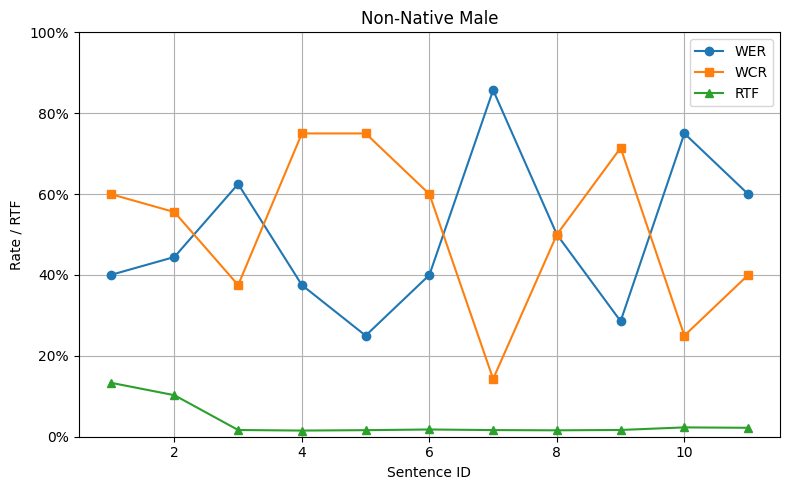

In [10]:
import os
import time
import re
import torch
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.signal import resample_poly
from collections import defaultdict

# =========================================================
# CONFIG
# =========================================================
TARGET_WORD = "mute"   # word of interest (case-sensitive)
audio_dir = r"C:\Users\ayham\Desktop\Downloads\HMI SpeechRecognition Dataset\Audio Files HMI\Non-Native Male\wav"
transcript_path = r"C:\Users\ayham\Desktop\Downloads\HMI SpeechRecognition Dataset\Audio Files HMI\transcript.txt"
num_sentences = 11

# =========================================================
# Load reference sentence by ID
# =========================================================
def load_reference_by_id(path: str, sentence_id: int) -> str:
    prefix = f"{sentence_id}:"
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line.startswith(prefix):
                text = line[len(prefix):].strip()
                text = re.sub(r"\(.*?\)", "", text).strip()
                return text
    raise ValueError(f"Sentence ID {sentence_id} not found in transcript file")

# =========================================================
# Punctuation-aware tokenizer
# =========================================================
def tokenize_with_punctuation(text: str) -> list[str]:
    return re.findall(r"\w+|[^\w\s]", text)

# =========================================================
# Word-level alignment (Levenshtein)
# =========================================================
def align_words(ref_tokens, hyp_tokens):
    n, m = len(ref_tokens), len(hyp_tokens)
    dp = [[0] * (m + 1) for _ in range(n + 1)]

    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if ref_tokens[i - 1] == hyp_tokens[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(
                    dp[i - 1][j],
                    dp[i][j - 1],
                    dp[i - 1][j - 1]
                )

    i, j = n, m
    ops = []
    while i > 0 or j > 0:
        if i > 0 and j > 0 and ref_tokens[i - 1] == hyp_tokens[j - 1]:
            ops.append(("CORRECT", ref_tokens[i - 1]))
            i -= 1
            j -= 1
        elif i > 0 and j > 0 and dp[i][j] == dp[i - 1][j - 1] + 1:
            ops.append(("SUB", ref_tokens[i - 1], hyp_tokens[j - 1]))
            i -= 1
            j -= 1
        elif i > 0 and dp[i][j] == dp[i - 1][j] + 1:
            ops.append(("DEL", ref_tokens[i - 1]))
            i -= 1
        else:
            ops.append(("INS", hyp_tokens[j - 1]))
            j -= 1

    return reversed(ops)

# =========================================================
# Silero STT transcription
# =========================================================
def transcribe_audio(model, decoder, prepare_model_input, path: str):
    start_time = time.time()
    audio, sr = sf.read(path)
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)
    if sr != 16000:
        audio = resample_poly(audio, 16000, sr)
        sr = 16000

    audio_tensor = torch.from_numpy(audio).float().unsqueeze(0)
    input_tensor = prepare_model_input(audio_tensor, device="cpu")

    with torch.no_grad():
        output = model(input_tensor)

    recognized_text = decoder(output[0].cpu())
    processing_time = time.time() - start_time
    return recognized_text, processing_time, len(audio)/sr

# =========================================================
# MAIN
# =========================================================
if __name__ == "__main__":

    wer_list, wcr_list, rtf_list = [], [], []
    total_wer, total_wcr, total_rtf = 0.0, 0.0, 0.0

    # Word-level counts for all words
    word_counts = defaultdict(lambda: {"TP":0, "FP":0, "FN":0})

    # =============================
    # Load Silero model ONCE
    # =============================
    device = torch.device("cpu")
    model, decoder, utils = torch.hub.load(
        repo_or_dir="snakers4/silero-models",
        model="silero_stt",
        language="en",
        device=device
    )
    (_, _, _, prepare_model_input) = utils

    # =============================
    # Process each sentence
    # =============================
    for sentence_id in range(1, num_sentences+1):

        print("\n" + "="*60)
        print(f"Processing sentence {sentence_id}")
        print("="*60)

        audio_path = os.path.join(audio_dir, f"{sentence_id}.wav")
        reference_text = load_reference_by_id(transcript_path, sentence_id)
        print("\nReference text:", reference_text)

        recognized_text, processing_time, audio_duration = transcribe_audio(model, decoder, prepare_model_input, audio_path)
        print("Recognized text:", recognized_text)

        ref_tokens = tokenize_with_punctuation(reference_text)
        rec_tokens = tokenize_with_punctuation(recognized_text)

        ops = list(align_words(ref_tokens, rec_tokens))

        # Update word-level counts
        for op in ops:
            if op[0] == "CORRECT":
                word_counts[op[1]]["TP"] += 1
            elif op[0] == "SUB":
                ref_w, hyp_w = op[1], op[2]
                word_counts[ref_w]["FN"] += 1
                word_counts[hyp_w]["FP"] += 1
            elif op[0] == "DEL":
                word_counts[op[1]]["FN"] += 1
            elif op[0] == "INS":
                word_counts[op[1]]["FP"] += 1

        # WER/WCR
        subs = sum(1 for o in ops if o[0]=="SUB")
        dels = sum(1 for o in ops if o[0]=="DEL")
        ins = sum(1 for o in ops if o[0]=="INS")
        wer = (subs + dels + ins)/len(ref_tokens)
        wcr = (len(ref_tokens) - subs - dels)/len(ref_tokens)

        wer_list.append(wer)
        wcr_list.append(wcr)
        total_wer += wer
        total_wcr += wcr
        rtf = processing_time / audio_duration
        rtf_list.append(rtf)
        total_rtf += rtf

        print(f"WER: {wer:.2%}, WCR: {wcr:.2%}, Audio dur: {audio_duration:.2f}s, Processing: {processing_time:.2f}s, RTF: {rtf:.3f}")

    # =========================================================
    # Per-word metrics for TARGET_WORD
    # =========================================================
    TP = word_counts[TARGET_WORD]["TP"]
    FP = word_counts[TARGET_WORD]["FP"]
    FN = word_counts[TARGET_WORD]["FN"]
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = (2*precision*recall/(precision+recall)) if (precision+recall) > 0 else 0.0

    print("\n" + "="*60)
    print(f"Metrics for word '{TARGET_WORD}': Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

    # =========================================================
    # Macro / Micro averages over vocabulary
    # =========================================================
    macro_prec = 0.0
    macro_rec = 0.0
    for w, counts in word_counts.items():
        TP_w, FP_w, FN_w = counts["TP"], counts["FP"], counts["FN"]
        macro_prec += TP_w / (TP_w + FP_w) if (TP_w + FP_w) > 0 else 0
        macro_rec += TP_w / (TP_w + FN_w) if (TP_w + FN_w) > 0 else 0
    macro_prec /= len(word_counts)
    macro_rec /= len(word_counts)

    total_TP = sum(c["TP"] for c in word_counts.values())
    total_FP = sum(c["FP"] for c in word_counts.values())
    total_FN = sum(c["FN"] for c in word_counts.values())
    micro_prec = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
    micro_rec = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0

    print("\nMacro-averaged: Precision={:.3f}, Recall={:.3f}".format(macro_prec, macro_rec))
    print("Micro-averaged: Precision={:.3f}, Recall={:.3f}".format(micro_prec, micro_rec))

    # =========================================================
    # Average WER/WCR/RTF
    # =========================================================
    print("\n" + "="*60)
    print(f"AVERAGE WER: {total_wer/num_sentences:.2%}")
    print(f"AVERAGE WCR: {total_wcr/num_sentences:.2%}")
    print(f"AVERAGE RTF: {total_rtf/num_sentences:.3f}")

    # =========================================================
    # Plot WER/WCR/RTF
    # =========================================================
    sentence_ids = list(range(1, num_sentences+1))
    plt.figure(figsize=(8,5))
    plt.plot(sentence_ids, wer_list, marker='o', label="WER")
    plt.plot(sentence_ids, wcr_list, marker='s', label="WCR")
    plt.plot(sentence_ids, rtf_list, marker='^', label="RTF")
    plt.title("Non-Native Male")
    plt.xlabel("Sentence ID")
    plt.ylabel("Rate / RTF")
    plt.ylim(0,1)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



REFERENCE TEXT:
 My father made him an offer he could not refuse. Held a gun to his head, and assured him that either his brain or his signature would be on the contract. True story.

RECOGNIZED TEXT:
 My father may his another he could den refuse. Held a gone to gist head, and azure Ed his that either his brain or his signature would be on the contract. Truth toy.

WORD-LEVEL ALIGNMENT (REF → HYP)
CORRECT : My
CORRECT : father
DEL     : made  →  <eps>
SUB     : him  →  may
SUB     : an  →  his
SUB     : offer  →  another
CORRECT : he
CORRECT : could
SUB     : not  →  den
CORRECT : refuse
CORRECT : .
CORRECT : Held
CORRECT : a
SUB     : gun  →  gone
CORRECT : to
SUB     : his  →  gist
CORRECT : head
CORRECT : ,
CORRECT : and
INS     : <eps> →  azure
SUB     : assured  →  Ed
SUB     : him  →  his
CORRECT : that
CORRECT : either
CORRECT : his
CORRECT : brain
CORRECT : or
CORRECT : his
CORRECT : signature
CORRECT : would
CORRECT : be
CORRECT : on
CORRECT : the
CORRECT : contract
CORRECT 

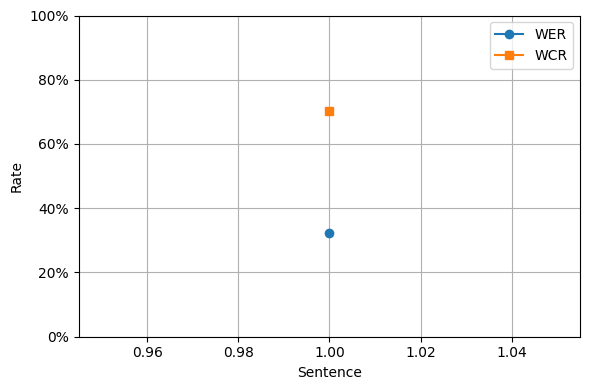

In [8]:
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from collections import defaultdict

# =========================================================
# CONFIG
# =========================================================
TARGET_WORD = "gun"
num_sentences = 1

# =========================================================
# FIXED INPUT TEXTS
# =========================================================
REFERENCE_TEXT = (
    "My father made him an offer he could not refuse. Held a gun to his head, and assured him that either his brain or his signature would be on the contract. True story."
)

RECOGNIZED_TEXT = (
    "My father may his another he could den refuse. Held a gone to gist head, and azure Ed his that either his brain or his signature would be on the contract. Truth toy."
)

# =========================================================
# Punctuation-aware tokenizer
# =========================================================
def tokenize_with_punctuation(text):
    return re.findall(r"\w+|[^\w\s]", text)

# =========================================================
# Word-level alignment (Levenshtein)
# =========================================================
def align_words(ref_tokens, hyp_tokens):
    n, m = len(ref_tokens), len(hyp_tokens)
    dp = [[0] * (m + 1) for _ in range(n + 1)]

    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if ref_tokens[i - 1] == hyp_tokens[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(
                    dp[i - 1][j],      # deletion
                    dp[i][j - 1],      # insertion
                    dp[i - 1][j - 1]   # substitution
                )

    i, j = n, m
    ops = []
    while i > 0 or j > 0:
        if i > 0 and j > 0 and ref_tokens[i - 1] == hyp_tokens[j - 1]:
            ops.append(("CORRECT", ref_tokens[i - 1]))
            i -= 1
            j -= 1
        elif i > 0 and j > 0 and dp[i][j] == dp[i - 1][j - 1] + 1:
            ops.append(("SUB", ref_tokens[i - 1], hyp_tokens[j - 1]))
            i -= 1
            j -= 1
        elif i > 0 and dp[i][j] == dp[i - 1][j] + 1:
            ops.append(("DEL", ref_tokens[i - 1]))
            i -= 1
        else:
            ops.append(("INS", hyp_tokens[j - 1]))
            j -= 1

    return list(reversed(ops))

# =========================================================
# MAIN
# =========================================================
print("\nREFERENCE TEXT:\n", REFERENCE_TEXT)
print("\nRECOGNIZED TEXT:\n", RECOGNIZED_TEXT)

ref_tokens = tokenize_with_punctuation(REFERENCE_TEXT)
rec_tokens = tokenize_with_punctuation(RECOGNIZED_TEXT)

ops = align_words(ref_tokens, rec_tokens)

# =========================================================
# DISPLAY ALIGNMENT OPERATIONS
# =========================================================
print("\n" + "=" * 70)
print("WORD-LEVEL ALIGNMENT (REF → HYP)")
print("=" * 70)

for op in ops:
    if op[0] == "CORRECT":
        print(f"CORRECT : {op[1]}")
    elif op[0] == "SUB":
        print(f"SUB     : {op[1]}  →  {op[2]}")
    elif op[0] == "DEL":
        print(f"DEL     : {op[1]}  →  <eps>")
    elif op[0] == "INS":
        print(f"INS     : <eps> →  {op[1]}")

# =========================================================
# COUNT WORD-LEVEL METRICS
# =========================================================
word_counts = defaultdict(lambda: {"TP": 0, "FP": 0, "FN": 0})

for op in ops:
    if op[0] == "CORRECT":
        word_counts[op[1]]["TP"] += 1
    elif op[0] == "SUB":
        ref_w, hyp_w = op[1], op[2]
        word_counts[ref_w]["FN"] += 1
        word_counts[hyp_w]["FP"] += 1
    elif op[0] == "DEL":
        word_counts[op[1]]["FN"] += 1
    elif op[0] == "INS":
        word_counts[op[1]]["FP"] += 1

# =========================================================
# WER / WCR
# =========================================================
subs = sum(1 for o in ops if o[0] == "SUB")
dels = sum(1 for o in ops if o[0] == "DEL")
ins  = sum(1 for o in ops if o[0] == "INS")

wer = (subs + dels + ins) / len(ref_tokens)
wcr = (len(ref_tokens) - subs - dels) / len(ref_tokens)

print("\n" + "=" * 70)
print(f"WER: {wer:.2%}")
print(f"WCR: {wcr:.2%}")

# =========================================================
# PER-WORD METRICS
# =========================================================
TP = word_counts[TARGET_WORD]["TP"]
FP = word_counts[TARGET_WORD]["FP"]
FN = word_counts[TARGET_WORD]["FN"]

precision = TP / (TP + FP) if TP + FP > 0 else 0.0
recall    = TP / (TP + FN) if TP + FN > 0 else 0.0
f1        = (2 * precision * recall / (precision + recall)) if precision + recall > 0 else 0.0

print("\n" + "=" * 70)
print(f"Metrics for word '{TARGET_WORD}':")
print(f"Precision = {precision:.3f}")
print(f"Recall    = {recall:.3f}")
print(f"F1-score  = {f1:.3f}")

# =========================================================
# SUMMARY COUNTS
# =========================================================
print("\n" + "=" * 70)
print("ALIGNMENT SUMMARY")
print("=" * 70)
print(f"Correct     : {sum(1 for o in ops if o[0]=='CORRECT')}")
print(f"Substitute  : {subs}")
print(f"Delete      : {dels}")
print(f"Insert      : {ins}")

# =========================================================
# PLOT WER / WCR
# =========================================================
plt.figure(figsize=(6, 4))
plt.plot([1], [wer], marker='o', label="WER")
plt.plot([1], [wcr], marker='s', label="WCR")
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlabel("Sentence")
plt.ylabel("Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
